# Nonnegative Matrix Factorization Testing

Some tests with the nonnegative matrix factorization code and the Scikit-learn package

In [61]:
import sys
import logging
from imp import reload
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
import sklearn.decomposition as skd
sys.path.append('/home/wtb2/Documents/solarnmf')
import solarnmf as snf
reload(snf)

<module 'solarnmf' from '/home/wtb2/Documents/solarnmf/solarnmf/__init__.py'>

In [63]:
#set logging to debug
ntbk_logger = logging.getLogger()
ntbk_logger.level = logging.DEBUG

## Matrices: two-dimensional tests

First, we will use the solarNMF code to generate some sample observations.

In [64]:
obs = snf.DataMaker('simulation','matrix',p=5,nx=100,ny=100,ngrid_x=20,ngrid_y=20)

INFO:DataMaker:Setting nx = 100
INFO:DataMaker:Setting ny = 100
INFO:DataMaker:Setting p = 5


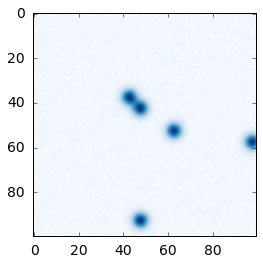

In [65]:
target,T = obs.make_t_matrix()
plt.imshow(T,cmap='Blues')

Now try to use scikit-learn to do the NMF decomposition.

In [66]:
model = skd.NMF(n_components=5,init='nndsvd',random_state=0,verbose=0,alpha=0,l1_ratio=1e-7)

In [67]:
U = model.fit_transform(T)
V = model.components_
A = np.dot(U,V)
print('(%d,%d), (%d,%d), (%d,%d)'%(np.shape(A)[0],np.shape(A)[1],np.shape(U)[0],np.shape(U)[1],
                                   np.shape(V)[0],np.shape(V)[1]))
print('error = %f'%model.reconstruction_err_)

(100,100), (100,5), (5,100)
error = 1.316798


Use our plotter function to plot the results.

In [68]:
plotter = snf.Plotter('simulation','matrix',U,V,A,T,target=target)

INFO:Plotter:Finding peaks from separated images
DEBUG:Plotter:(93,48)
DEBUG:Plotter:(53,62)
DEBUG:Plotter:(38,43)
DEBUG:Plotter:(57,98)
DEBUG:Plotter:(12,70)


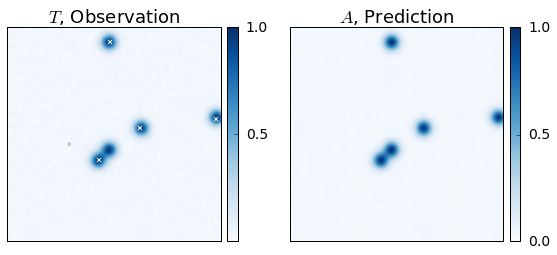

In [69]:
plotter.plot_obs_pred_total(peak_id=True)

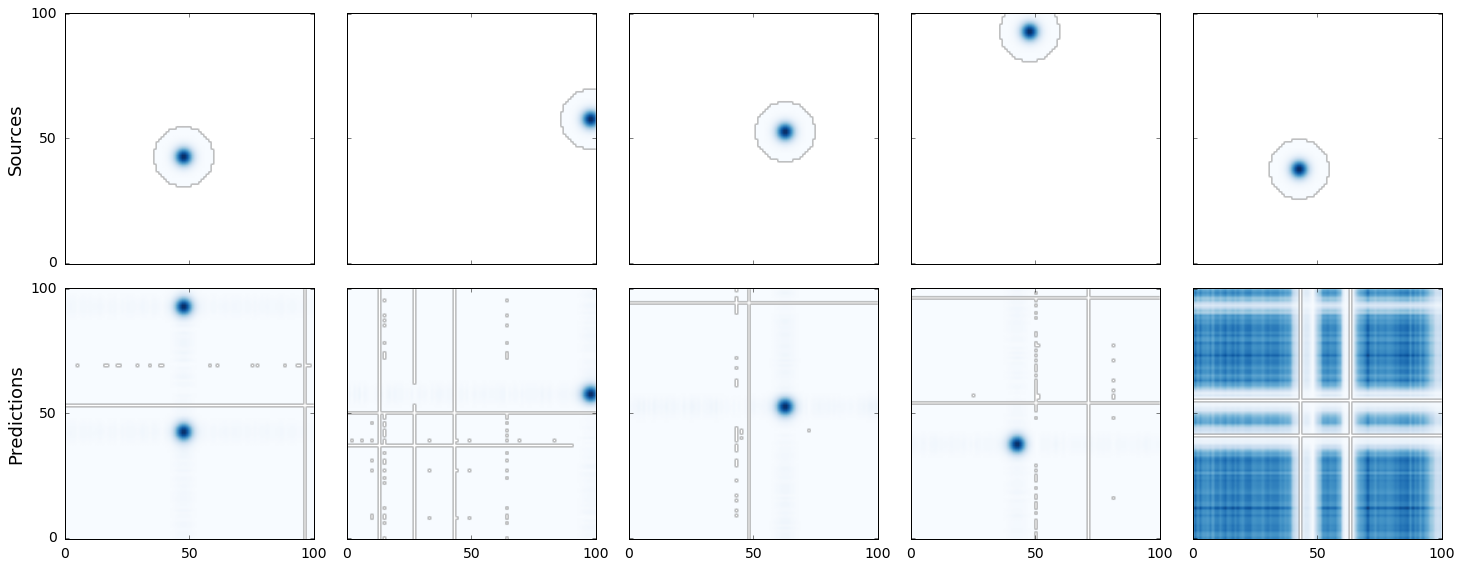

In [70]:
plotter.fig_size = (4*max(plotter.q,len(plotter.target)),4*2)
plotter.plot_obs_pred_sources()

Here, it's obvious that NMF does a good job of picking out the individual sources because we have guessed the correct number of sources. However, we want to be able to estimate the true number of sources and not overfit our model.

Let's try searching $(\alpha,\ell_1)$ space for the best values of these parameters.

In [71]:
alpha_guess = np.linspace(0,3.5,10)
l1_guess = np.linspace(0,1,10)

In [72]:
div_mat = np.zeros([len(alpha_guess),len(l1_guess)])
iters_mat = np.zeros([len(alpha_guess),len(l1_guess)])

In [73]:
for i in range(len(alpha_guess)):
    for j in range(len(l1_guess)):
        model = skd.NMF(n_components=5,init='random',random_state=0,alpha=alpha_guess[i],l1_ratio=l1_guess[j],
                    max_iter=5000,verbose=0,shuffle=True)
        model.fit(T)
        div_mat[i,j] = model.reconstruction_err_
        iters_mat[i,j] = model.n_iter_

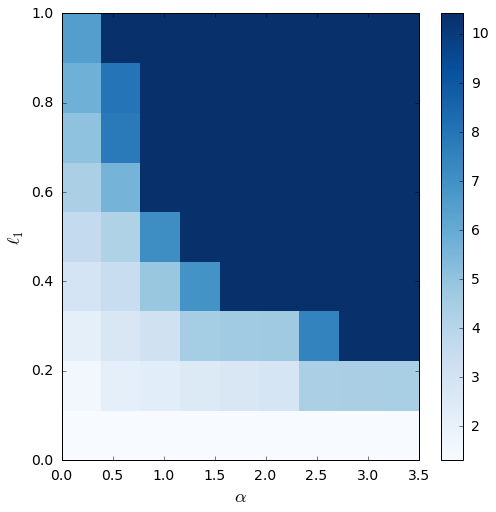

In [74]:
Alpha,L1 = np.meshgrid(alpha_guess,l1_guess)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
surf=ax.pcolormesh(Alpha,L1,div_mat,cmap=plt.cm.Blues)
ax.set_ylim([np.min(l1_guess),np.max(l1_guess)])
ax.set_xlim([np.min(alpha_guess),np.max(alpha_guess)])
ax.set_ylabel(r'$\ell_1$',fontsize=18)
ax.set_xlabel(r'$\alpha$',fontsize=18)
fig.colorbar(surf,ax=ax)
plt.show()

Since $\ell_1$ controls the sparseness and we are really interested in the smoothness parameter ($\alpha$) here, let's fix $\ell_1=0.5$ (balance between $L_1$ and $L_2$ penalty terms).

Now, let's try several different guesses for the number of sources and plot the resulting error.

In [75]:
sources_guess = np.arange(1,20,1)
div = []
iters = []
for sg in sources_guess:
    model = NMF(n_components=int(sg),init='random',random_state=0,alpha=1.5,l1_ratio=0.2,max_iter=5000,verbose=0,
               shuffle=True)
    u = model.fit_transform(T)
    div.append(model.reconstruction_err_)
    iters.append(model.n_iter_)

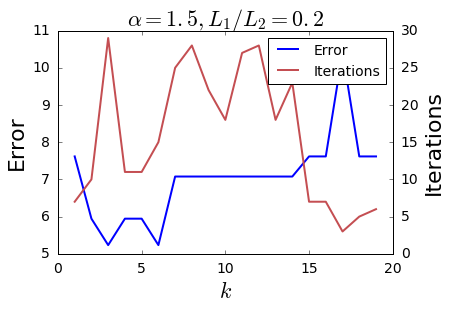

In [76]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
line1 = ax.plot(sources_guess,div,label=r'Error')
line2 = ax2.plot(sources_guess,iters,color=sns.color_palette('deep')[2],label=r'Iterations')
lines = line1 + line2
labels = []
[labels.append(l.get_label()) for l in lines]
ax.set_ylabel(r'Error')
ax2.set_ylabel(r'Iterations')
ax.set_xlabel(r'$k$')
ax.set_title(r'$\alpha=1.5, L_1/L_2=0.2$')
ax2.legend(lines,labels)

Note that the error curve as a function of guessed $k$ in this case has a minimum near $k=5$, indicating that this number of sources is the best fit to the model. Because the error increases at large $k$, we seem to not be overfitting.

What if we turn off the smoothing parameter $\alpha$?

In [77]:
div_a0 = []
iters_a0 = []
for sg in sources_guess:
    model = NMF(n_components=int(sg),init='random',random_state=0,alpha=0.0,l1_ratio=0.2,max_iter=5000,verbose=0,
               shuffle=True)
    u = model.fit_transform(T)
    div_a0.append(model.reconstruction_err_)
    iters_a0.append(model.n_iter_)

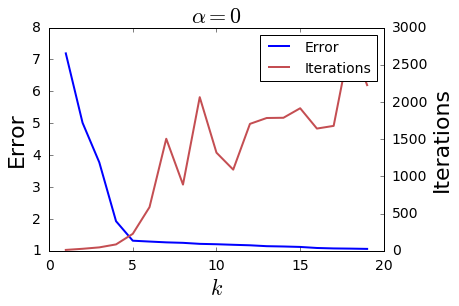

In [78]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
line1 = ax.plot(sources_guess,div_a0,label=r'Error')
line2 = ax2.plot(sources_guess,iters_a0,color=sns.color_palette('deep')[2],label=r'Iterations')
lines = line1 + line2
labels = []
[labels.append(l.get_label()) for l in lines]
ax.set_ylabel(r'Error')
ax2.set_ylabel(r'Iterations')
ax.set_xlabel(r'$k$')
ax.set_title(r'$\alpha=0$')
ax2.legend(lines,labels)

By turning off the smoothness parameter, we allow for overfitting: as $k\to\infty$, the error in our model fit goes to 0.

## Time series: one-dimensional tests

In [170]:
q_actual = 7
q_guessed = 7

First, generate some sample observations.

In [171]:
obs_ts = snf.DataMaker('simulation','timeseries',p=q_actual,nx=500,ny=500,angle=45.0,ngrid_x=10,ngrid_y=10)

INFO:DataMaker:Setting angle = 45.000000
INFO:DataMaker:Setting nx = 500
INFO:DataMaker:Setting ny = 500
INFO:DataMaker:Setting p = 7


In [172]:
target_ts,T_ts,Tmat_ts = obs_ts.make_t_matrix()

Use Scikit-learn to do the NMF routine.

In [173]:
U_ts,V_ts,n_iter = skd.nmf.non_negative_factorization(Tmat_ts,n_components=q_guessed,init='nndsvd',alpha=0.5,l1_ratio=0.0,
                                             regularization='both')

In [174]:
A_ts = np.dot(U_ts,V_ts)
print('(%d,%d), (%d,%d), (%d,%d)'%(np.shape(A_ts)[0],np.shape(A_ts)[1],np.shape(U_ts)[0],np.shape(U_ts)[1],
                                   np.shape(V_ts)[0],np.shape(V_ts)[1]))

(707,707), (707,7), (7,707)


Now plot the results.

In [175]:
ts_plotter = snf.Plotter('simulation','timeseries',U_ts,V_ts,A_ts,T_ts,target=target_ts,angle=45.0,q=q_guessed,Tmat=Tmat_ts)

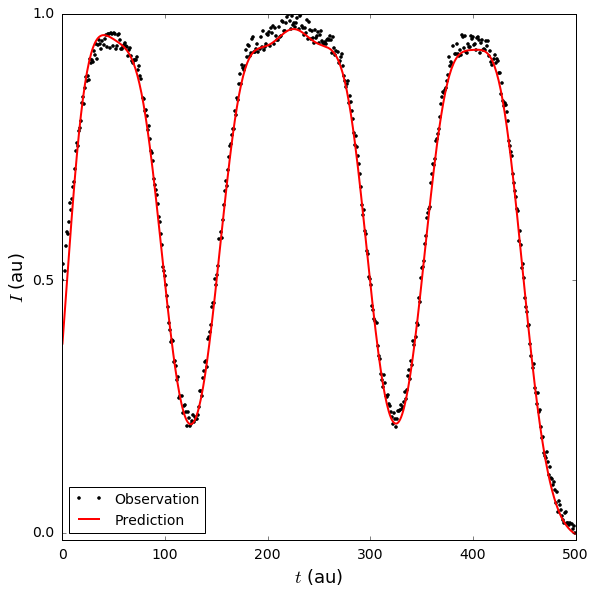

In [176]:
ts_plotter.plot_obs_pred_total()

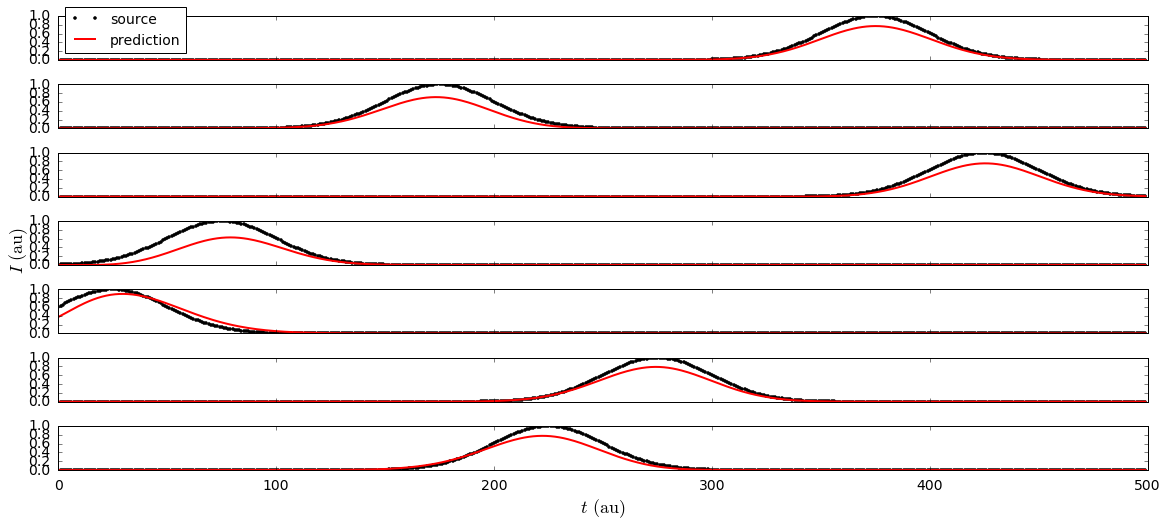

In [177]:
ts_plotter.fig_size = (16,1*max(ts_plotter.q,len(plotter.target)),)
ts_plotter.plot_obs_pred_sources()

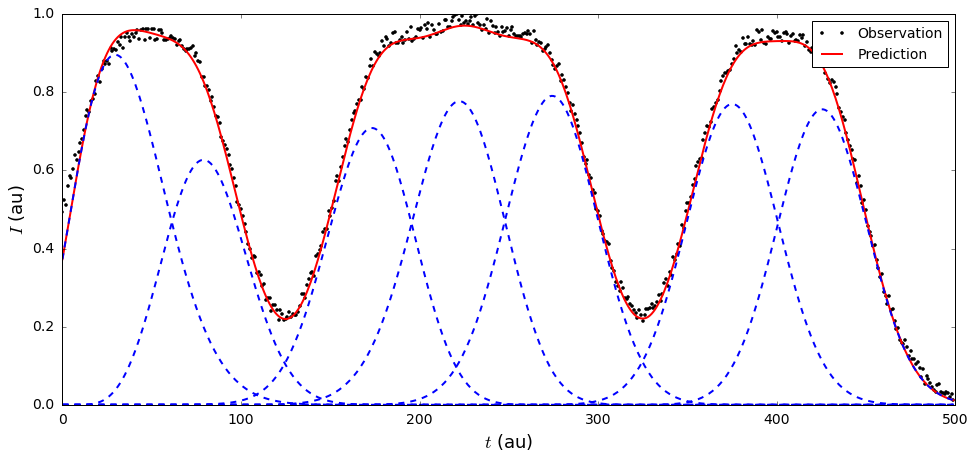

In [178]:
ts_plotter.plot_obs_pred_total_sources_ts()

Estimate the error from our fit.

In [179]:
np.linalg.norm(Tmat_ts-A_ts,ord='fro')

6.8971912517514307

Seems that the non-negative factorization function should be used instead for these. It is unclear what the difference is. Let's compare against our homegrown NMF method.

In [167]:
#Set parameters
params = {'eps':1.0e-8,'psi':1.0e-16,'sparse_u':0.125,'sparse_v':0.125,'reg_0':20.0,'reg_tau':50.0,'max_i':75,'r':5,'r_iter':10}
params['lambda_1'] = 0.0001
params['lambda_2'] = 0.0001
params['alpha'] = 1.5
params['l_toeplitz'] = 5
params['div_measure'] = 'multiplicative_reg_sparse'
params['update_rules'] = 'chen_cichocki_reg_sparse'

In [168]:
minimizer = snf.Learner(Tmat_ts,q_guessed,params)

INFO:Learner:Using multiplicative_reg_sparse divergence measure.
INFO:Learner:Using chen_cichocki_reg_sparse update rules.
INFO:Learner:Guessed number of sources 5


In [54]:
utemp,vtemp,atemp = minimizer.initialize_uva()

INFO:Learner:Initialization iteration 0
INFO:Learner:At iteration 0 with divergence 2054.71848776
INFO:Learner:Initialization iteration 1
INFO:Learner:At iteration 0 with divergence 2038.52667213
INFO:Learner:Initialization iteration 2
INFO:Learner:At iteration 0 with divergence 2056.40461172
INFO:Learner:Initialization iteration 3
INFO:Learner:At iteration 0 with divergence 2052.7354658
INFO:Learner:Initialization iteration 4
INFO:Learner:At iteration 0 with divergence 2048.80302363


In [55]:
u_c,v_c,a_c,div = minimizer.minimize_div(utemp,vtemp,minimizer.max_i)

INFO:Learner:At iteration 0 with divergence 113.380734408
INFO:Learner:At iteration 10 with divergence 85.7793060531
INFO:Learner:At iteration 20 with divergence 48.9957987722
INFO:Learner:At iteration 30 with divergence 32.2941440087
INFO:Learner:At iteration 40 with divergence 25.1075436404
INFO:Learner:At iteration 50 with divergence 23.0004218346
INFO:Learner:At iteration 60 with divergence 21.9037429739
INFO:Learner:At iteration 70 with divergence 21.143687939


In [56]:
new_ts_plotter = snf.Plotter('simulation','timeseries',u_c,v_c,a_c,T_ts,div=div,target=target_ts,angle=45.0,q=q_guessed,Tmat=Tmat_ts)

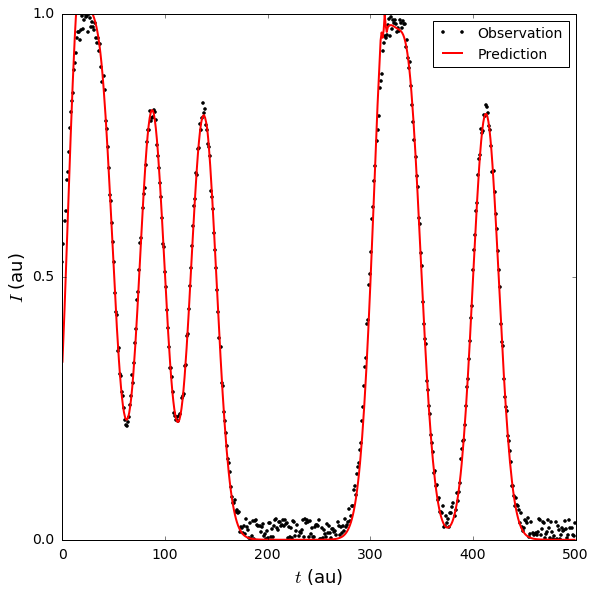

In [57]:
new_ts_plotter.plot_obs_pred_total()

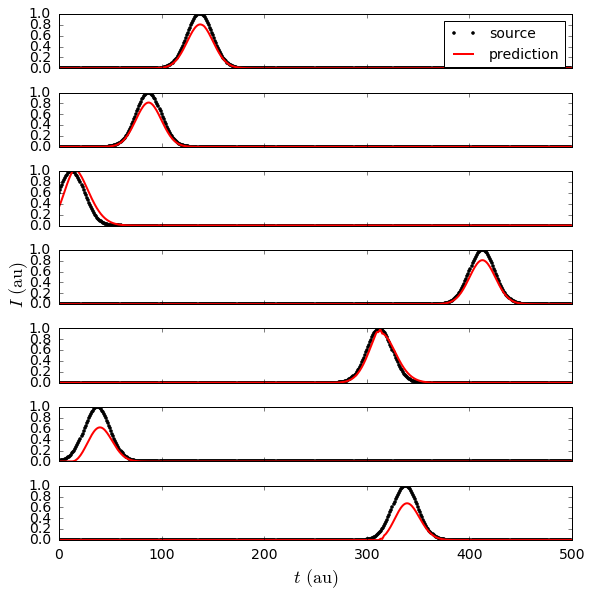

In [58]:
new_ts_plotter.plot_obs_pred_sources()

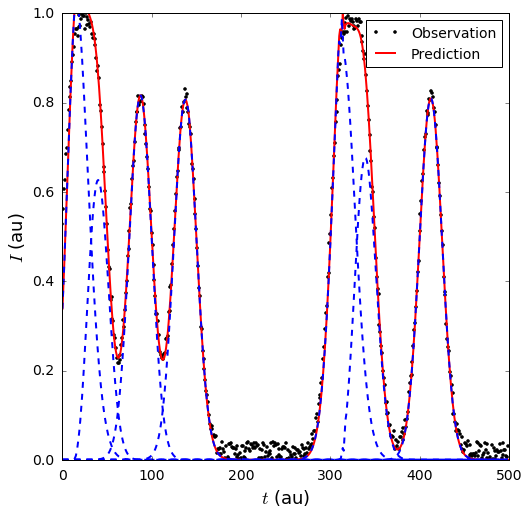

In [59]:
new_ts_plotter.plot_obs_pred_total_sources_ts()

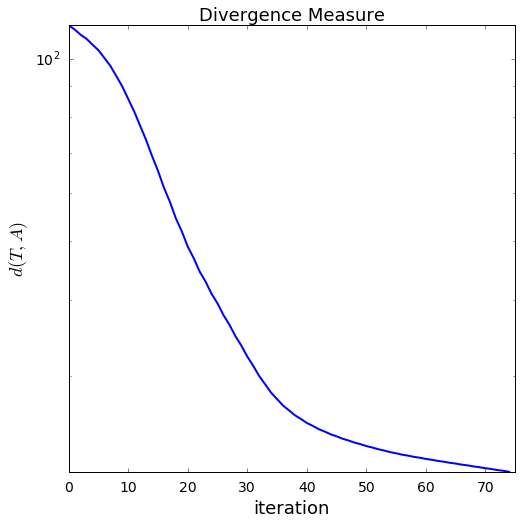

In [60]:
new_ts_plotter.plot_div()

## Variable $k$ in Time series NMF

Now, we will create an observation with $k_{actual}$ sources.

In [370]:
k_actual = 3

In [371]:
vark_dm = snf.DataMaker('simulation','timeseries',p=k_actual,nx=500,ny=500,angle=45.0,ngrid_x=25,ngrid_y=25)
vark_target,vark_T,vark_Tmat = vark_dm.make_t_matrix()

INFO:DataMaker:Setting angle = 45.000000
INFO:DataMaker:Setting nx = 500
INFO:DataMaker:Setting ny = 500
INFO:DataMaker:Setting p = 3


Set the regularization and sparseness parameters.

In [372]:
vark_alpha = 2
vark_sparseness = 1e-4

See what the results look like when we guess the correct number of sources.

In [373]:
u,v,n_iter = skd.nmf.non_negative_factorization(vark_Tmat,n_components=k_actual,init='random',alpha=vark_alpha,
                                                          l1_ratio=vark_sparseness,regularization='both')
a = np.dot(u,v)

In [374]:
vark_plotter = snf.Plotter('simulation','timeseries',u,v,a,vark_T,target=vark_target,angle=45.0,q=k_actual,
                           Tmat=vark_Tmat)

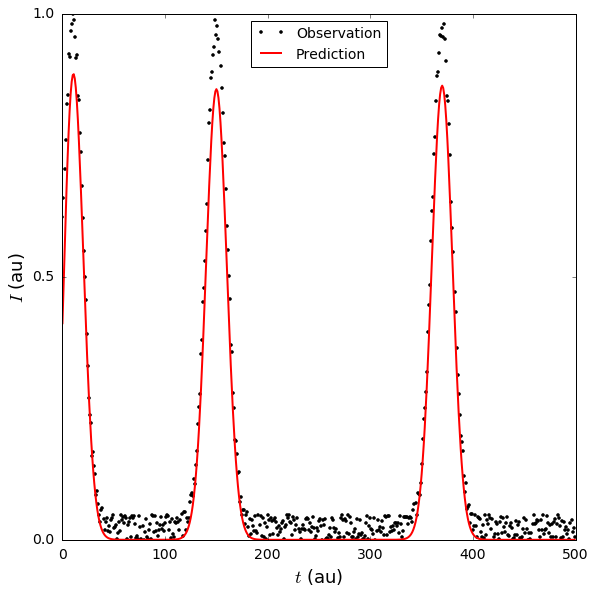

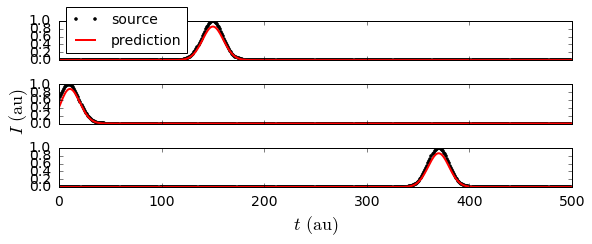

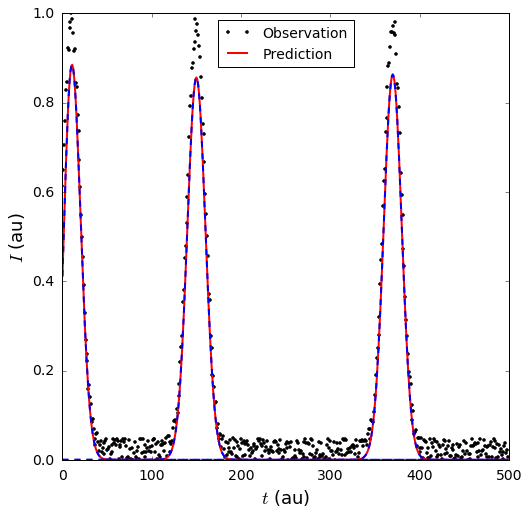

In [375]:
vark_plotter.plot_obs_pred_total()
oldfs = vark_plotter.fig_size
vark_plotter.fig_size = (8,k_actual)
vark_plotter.plot_obs_pred_sources()
vark_plotter.fig_size = oldfs
vark_plotter.plot_obs_pred_total_sources_ts()

Now, we will vary the guessed number of sources and calculate the error for each guess $k_{guess}$. Ideally, we will have a minimum at $k_{guess}=k_{actual}$.

In [376]:
vark_error = []
vark_iters = []
vark_kguess = np.arange(1,24,1)

In [377]:
for k in vark_kguess:
    u,v,n_iter = skd.nmf.non_negative_factorization(vark_Tmat,n_components=int(k),init='random',alpha=vark_alpha,
                                                          l1_ratio=vark_sparseness,regularization='both',
                                                   max_iter=1000)
    a = np.dot(u,v)
    vark_iters.append(n_iter)
    vark_error.append(skd.nmf._safe_compute_error(vark_Tmat,u,v))
    print("k=%d, error=%.3f, iters=%d"%(k,vark_error[-1],vark_iters[-1]))


k=1, error=24.386, iters=566
k=2, error=18.181, iters=544
k=3, error=5.508, iters=18
k=4, error=5.508, iters=18
k=5, error=5.508, iters=16
k=6, error=5.508, iters=22
k=7, error=5.271, iters=282
k=8, error=5.271, iters=348
k=9, error=5.509, iters=21
k=10, error=5.269, iters=93
k=11, error=5.276, iters=240
k=12, error=5.274, iters=469
k=13, error=5.268, iters=918
k=14, error=5.270, iters=414
k=15, error=5.269, iters=370
k=16, error=5.270, iters=161
k=17, error=5.269, iters=345
k=18, error=5.272, iters=414
k=19, error=5.271, iters=999
k=20, error=5.268, iters=806
k=21, error=5.268, iters=672
k=22, error=5.268, iters=661
k=23, error=5.268, iters=357


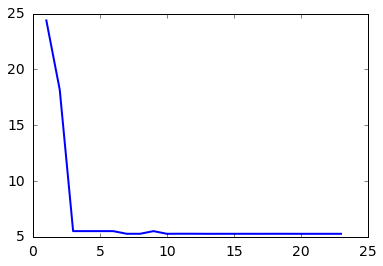

In [378]:
plt.plot(vark_kguess,vark_error)

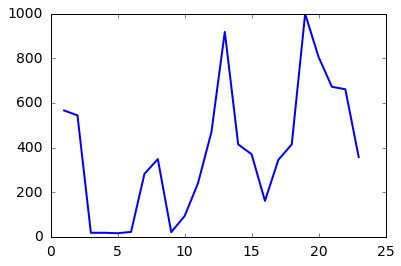

In [379]:
plt.plot(vark_kguess,vark_iters)